# Quadratic optimisation example

In this notebook we illustrate the scalability of tempered SMC for simple quadratic optimization. This will allow us to verify empirically the derived asymptotics of the method.

## Imports

In [1]:
from collections import OrderedDict
from functools import partial 
import jax.numpy as jnp
from jax.random import normal
from jax import jit

import matplotlib.pyplot as plt
import numpy as np
from tensorflow_probability.substrates.jax.mcmc import MetropolisAdjustedLangevinAlgorithm, HamiltonianMonteCarlo, DualAveragingStepSizeAdaptation

from tempered_smc_optimization.smc_minimizer import infinitely_tempered_smc

In [2]:
@jit
def potential(x, k):
    res = jnp.sum(x ** 2, 1)
    return res

def m0(n, key, d):
    return (10 * normal(key, (n, d)),)

In [3]:
def mh_kernel(log_prob_fn):
    mcmc = HamiltonianMonteCarlo(log_prob_fn, step_size=1e-3, num_leapfrog_steps=50)
    return mcmc

In [4]:
means = OrderedDict()
stds = OrderedDict()
lambdas = OrderedDict()
particles_histories = OrderedDict()

In [5]:
ds = [1, 50, 500, 5000]
ns = np.empty_like(ds)

In [6]:
infinitely_tempered_smc_d = lambda d: infinitely_tempered_smc(potential, 100, 0.75, partial(m0, d=d), num_results=50,
                                                              max_lambda=1e3, max_n=1000, make_kernel=mh_kernel)

In [7]:
for i, d in enumerate(ds):
    
    particles_history_d, lambdas_d, n = infinitely_tempered_smc_d(d)
    particles_history_d = particles_history_d[0]
    n = np.array(n)
    lambdas_d = np.array(lambdas_d)
    particles_history_d = np.array(particles_history_d)
    
    lambdas_d = lambdas_d[:n+1]
    particles_history_d = particles_history_d[:n+1]
    
    mean_d = particles_history_d.mean(axis=1)
    std_d = particles_history_d.std(axis=1)
    
    means[d] = mean_d
    stds[d] = std_d
    lambdas[d] = lambdas_d
    


Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/1000 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/1000 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/1000 [00:00<?, ?it/s]

Tempering the potential, lambda=0.000000, max_lambda=1000.0:   0%|          | 0/1000 [00:00<?, ?it/s]

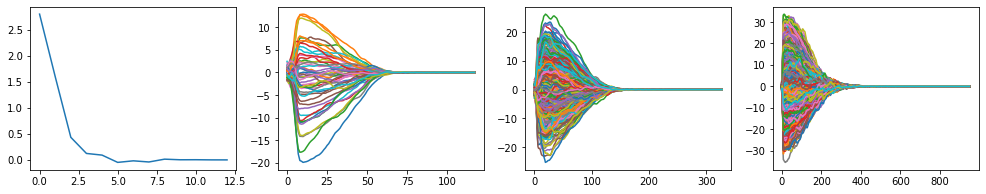

In [20]:
fig, axes = plt.subplots(ncols=len(ds), figsize=(17, 3))
for d, ax in zip(ds, axes):
    ax.plot(means[d], label="Mean")

fig.savefig("./figures/quadratic_convergence.png")


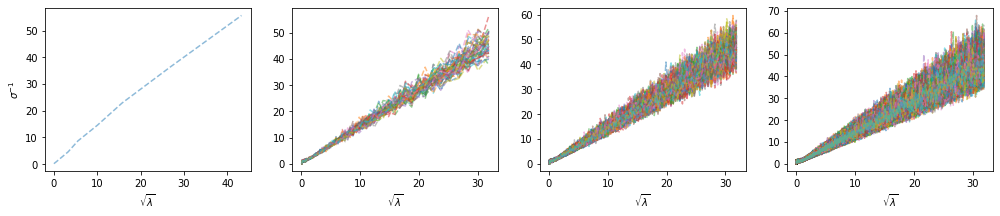

In [27]:
fig, axes = plt.subplots(ncols=len(ds), figsize=(17, 3))
for i, (d, ax) in enumerate(zip(ds, axes)):
    ax.plot(np.sqrt(lambdas[d][1:]), 1/stds[d][1:], label="Std", linestyle="--", alpha=0.5)
    ax.set_xlabel(r"$\sqrt{\lambda}$")
    if i == 0:
        ax.set_ylabel(r"$\sigma^{-1}$")
#     ax.semilogy(1. / np.sqrt(lambdas[d][1:]), label="Lambdas", alpha=0.33)

fig.savefig("./figures/quadratic_std_lambda.png")

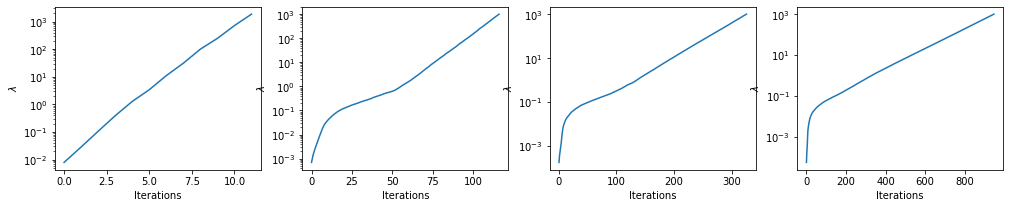

In [21]:
fig, axes = plt.subplots(ncols=len(ds), figsize=(17, 3))
for i, (d, ax) in enumerate(zip(ds, axes)):
    ax.semilogy(lambdas[d][1:], linestyle="-")
    ax.set_ylabel(r"$\lambda$")
    ax.set_xlabel(r"Iterations")

#     ax.semilogy(1. / np.sqrt(lambdas[d][1:]), label="Lambdas", alpha=0.33)

fig.savefig("./figures/quadratic_lambdas.png")